## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2024-02-09 13:12:58--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  2.01MB/s    in 0.5s    

2024-02-09 13:12:59 (2.01 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
! pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00


In [4]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk`
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [10]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)

    return inp, target

print(random_training_set(10,4)[0])  ## should return 8 chunks of 10 letters.
print(random_training_set(10,4)[1])  ## should return 8 chunks of 10 letters.

tensor([[94, 15, 27, 24, 22, 94, 29, 17, 14, 94],
        [94, 15, 10, 29, 17, 14, 27, 94, 18, 28],
        [27, 14, 94, 12, 24, 22, 22, 14, 23, 13],
        [18, 12, 17, 94, 17, 10, 31, 14, 73, 94]])
tensor([[96, 41, 14, 10, 27, 94, 23, 24, 23, 14],
        [14, 94, 29, 17, 34, 94, 15, 24, 27, 32],
        [94, 38, 21, 10, 27, 14, 23, 12, 14, 73],
        [73, 94, 32, 18, 29, 17, 94, 29, 17, 10]])


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [11]:
import torch.nn.functional as f

class RNN(nn.Module):

    def __init__(self, n_char, hidden_size, output_size,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        self.embed = nn.Embedding(n_char,hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.rnn = rnn_cell(hidden_size,hidden_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(hidden_size,output_size)

    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [12]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)

    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [13]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer (IL A UN PAS DE GRADIENT SIMILAIRE )
criterion = nn.CrossEntropyLoss() #chose criterion (C'EST NOTRE LOSS)

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp) # (DE TAILLE 16 TAILLE DU BATCH *80 NOMBRE DE CARCTERES *100: NOMBRE DE CLASSE)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 3s (100 0%) 2.5515]
Whe for ge ly t beere, oof or bavinchoe f ganse, und turn oud y gake
OUCHail te ar wit s, d is surrve  

 7s (200 1%) 2.4774]
Whe t I bermpor he he ke,
IN s orel Anthullill wel y, lin tht we, f athitred f,

I mirthe yomee'd adu  

 11s (300 1%) 2.5682]
Whad t wray thes seathitous t s my y ped f ghene
I'd a toure athorse hare of be bepom.
Theste I:

Thar 

 15s (400 2%) 2.3970]
Whof m; ppe ck d thethary me th chey s t f the tsse f t:
CI tot see wie isie tower be
GO:
TENETh hous  

 18s (500 2%) 2.4714]
Whoucoure t an; mery beerd c, dt I thar his he t, athy foucaratho tres panorder t t me da y st war se  

 22s (600 3%) 2.4292]
Wh me ain! alese pr t nd-t an t m by,
I'd.
STIO: tbu d cker k s our me, o RI ll isthe thesth, CHAstout 

 26s (700 3%) 2.4700]
Whatorise t it n alathe te wos he, wishe wighang th tot ysak ms haitit
I ngoungurtcrsto bll my the y s 

 29s (800 4%) 2.4821]
Whel t f be upiessis t s ce.
Whiny nd serer whicorestheay oma is hee mos mave wive smy wati

## Visualize loss

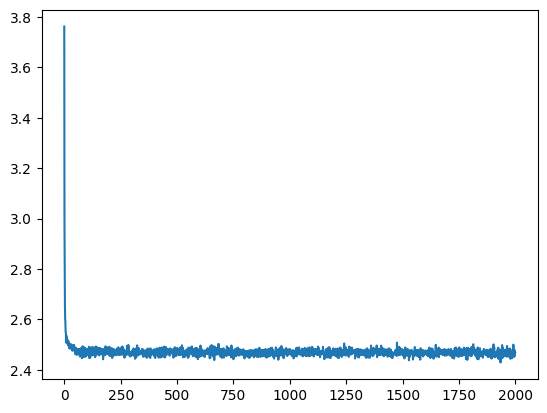

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [15]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

Tatyalarounoonond comivet hakonenay u wolome cot r.

S: he g icuds a l sst; m ollllans: mengre isilidadguroure mandeameted!
IIO wistINGRIn: hey te h,
T:
TYORKINIORied.
Pritheamy th ath tice watin perr,
----
Th per tourd som, lllathaco ha my s qunou st,


S:

Yo betherenotevesiveangrer anfaind call bond.


Ge wathencenel hadis, o myomat slfton: ind INourathere s s d m fond ane, y me momouirsotowimof:
Hang t
----
Thallo t mere the urous inss st thin ar t the, aned he belllllo s tourd bere d parsth men s thast f buchay manouse t ak ath the ar tost s anore t me thame mor he mayo y me be han he t he nghe thanyomyom
----
The ge he wind t hare s the se t y the n an he me the me athe t s the be the anoutou me the t he t the wind t be t he ande the me the t the he be me the the an hand he t athand he wind min the the t the
----
The the t the t the the the he the the the me the the the the the the the the the me thand the the the the the the the the the the the the the the the the me the t the t